In [1]:
import numpy as np
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### example 1 

- Credit 
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/2_BasicModels/kmeans.ipynb

In [33]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
full_data_x = mnist.train.images

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [43]:
from tensorflow.contrib.factorization import KMeans

# Parameters
num_steps = 50     # Total steps to train
batch_size = 1024  # The number of samples per batch
k = 25             # The number of clusters
num_classes = 10   # The 10 digits
num_features = 784 # Each image is 28x28 pixels

# Input images
X = tf.placeholder(tf.float32, shape=[None, num_features])
# Labels (for assigning a label to a centroid and testing)
Y = tf.placeholder(tf.float32, shape=[None, num_classes])

# K-Means Parameters
kmeans = KMeans(inputs=X, num_clusters=k, distance_metric='cosine',
                use_mini_batch=True)

# Build KMeans graph
(all_scores, cluster_idx, scores, cluster_centers_initialized, init_op,
train_op) = kmeans.training_graph()
cluster_idx = cluster_idx[0] # fix for cluster_idx being a tuple
avg_distance = tf.reduce_mean(scores)

# Initialize the variables (i.e. assign their default value)
init_vars = tf.global_variables_initializer()

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars, feed_dict={X: full_data_x})
sess.run(init_op, feed_dict={X: full_data_x})

# Training
for i in range(1, num_steps + 1):
    _, d, idx = sess.run([train_op, avg_distance, cluster_idx],
                         feed_dict={X: full_data_x})
    if i % 10 == 0 or i == 1:
        print("Step %i, Avg Distance: %f" % (i, d))


Step 1, Avg Distance: 0.330741
Step 10, Avg Distance: 0.221549
Step 20, Avg Distance: 0.219741
Step 30, Avg Distance: 0.218959
Step 40, Avg Distance: 0.218512
Step 50, Avg Distance: 0.218216


In [44]:
# Assign a label to each centroid
# Count total number of labels per centroid, using the label of each training
# sample to their closest centroid (given by 'idx')
counts = np.zeros(shape=(k, num_classes))
for i in range(len(idx)):
    counts[idx[i]] += mnist.train.labels[i]
# Assign the most frequent label to the centroid
labels_map = [np.argmax(c) for c in counts]
labels_map = tf.convert_to_tensor(labels_map)

# Evaluation ops
# Lookup: centroid_id -> label
cluster_label = tf.nn.embedding_lookup(labels_map, cluster_idx)
# Compute accuracy
correct_prediction = tf.equal(cluster_label, tf.cast(tf.argmax(Y, 1), tf.int32))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Test Model
test_x, test_y = mnist.test.images, mnist.test.labels
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

Test Accuracy: 0.7118


### example 2 

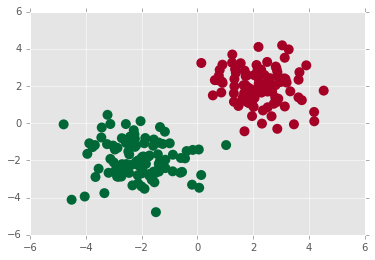

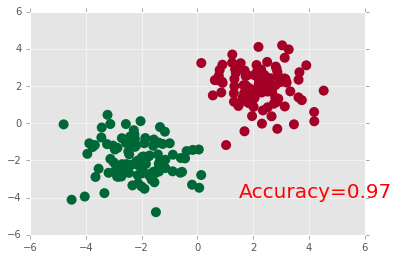

In [3]:
# credit 
# https://github.com/MorvanZhou/Tensorflow-Tutorial/blob/master/tutorial-contents/302_simple_classification.py


tf.set_random_seed(1)
np.random.seed(1)

# fake data
n_data = np.ones((100, 2))
x0 = np.random.normal(2*n_data, 1)      # class0 x shape=(100, 2)
y0 = np.zeros(100)                      # class0 y shape=(100, 1)
x1 = np.random.normal(-2*n_data, 1)     # class1 x shape=(100, 2)
y1 = np.ones(100)                       # class1 y shape=(100, 1)
x = np.vstack((x0, x1))  # shape (200, 2) + some noise
y = np.hstack((y0, y1))  # shape (200, )

# plot data
plt.scatter(x[:, 0], x[:, 1], c=y, s=100, lw=0, cmap='RdYlGn')
plt.show()

tf_x = tf.placeholder(tf.float32, x.shape)   # input x
tf_y = tf.placeholder(tf.int32, y.shape)     # input y

# neural network layers
###############
l1 = tf.layers.dense(tf_x, 10, tf.nn.relu)          # hidden layer
output = tf.layers.dense(l1, 2)                     # output layer

loss = tf.losses.sparse_softmax_cross_entropy(labels=tf_y, logits=output)           # compute cost
accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.squeeze(tf_y), predictions=tf.argmax(output, axis=1),)[1]
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
train_op = optimizer.minimize(loss)

sess = tf.Session()                                                                 # control training and others
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)     # initialize var in graph

###############
plt.ion()   # something about plotting
for step in range(100):
    # train and net output
    _, acc, pred = sess.run([train_op, accuracy, output], {tf_x: x, tf_y: y})
    if step % 2 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x[:, 0], x[:, 1], c=pred.argmax(1), s=100, lw=0, cmap='RdYlGn')
        plt.text(1.5, -4, 'Accuracy=%.2f' % acc, fontdict={'size': 20, 'color': 'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()